In [130]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


**Importing libraries**

In [131]:
import numpy as np
import pandas as pd
import codecs
from sklearn.feature_extraction.text import TfidfVectorizer

In [132]:
import matplotlib.pyplot as plt
%matplotlib inline

**Reading data**

In [133]:
wine_data = pd.read_csv('OSX_DS_assignment.csv')

In [134]:
wine_data.shape

(103322, 12)

Removing duplicate records if any from the dataset

In [135]:
wine_data.drop_duplicates(keep='last',inplace=True)

In [136]:
wine_data.shape

(95455, 12)

**Check for missing values**

Removing unwanted features

In [137]:
wine_data.drop('user_name',axis=1,inplace=True)

Identifying & dropping columns containing more than 50% of missing values

In [138]:
total = wine_data.isnull().sum().sort_values(ascending=False)
percent = (wine_data.isnull().sum()/wine_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Missing Percent'])
missing_data['Missing Percent'] = missing_data['Missing Percent'].apply(lambda x: x * 100)
missing_data.loc[missing_data['Missing Percent'] > 0][:10]

,Total,Missing Percent
region_2,53910,56.476874
designation,27363,28.665863
region_1,14804,15.508879
price,6514,6.824158
province,36,0.037714
country,36,0.037714


Dropping region_2 column as it contains more than 50 % of missing values

In [139]:
wine_data.drop('region_2',axis=1,inplace=True)

Change in climate has a effect on wine production.There are 36 records where province is missing.We can drop these records as the number is very less when we compare with total number of records.

In [140]:
wine_data.dropna(how='any',subset=['province','country'],inplace=True)

Resetting index

In [141]:
wine_data.reset_index(drop=True,inplace=True) 

In [142]:
wine_data.head(3)

,country,review_title,review_description,designation,points,price,province,region_1,winery,variety
0,Italy,Nicosia 2013 Vulkà Bianco (Etna),"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,Nicosia,White Blend
1,Portugal,Quinta dos Avidagos 2011 Avidagos Red (Douro),"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,Quinta dos Avidagos,Portuguese Red
2,US,Rainstorm 2013 Pinot Gris (Willamette Valley),"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Rainstorm,Pinot Gris


Imputing missing prices by the mode price of each country.

In [143]:
wine_data['price'] = wine_data.groupby(['country'])['price'].transform(lambda x: x.fillna(x.mode()[0]))

In [144]:
wine_data.head(3)

,country,review_title,review_description,designation,points,price,province,region_1,winery,variety
0,Italy,Nicosia 2013 Vulkà Bianco (Etna),"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,20.0,Sicily & Sardinia,Etna,Nicosia,White Blend
1,Portugal,Quinta dos Avidagos 2011 Avidagos Red (Douro),"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,Quinta dos Avidagos,Portuguese Red
2,US,Rainstorm 2013 Pinot Gris (Willamette Valley),"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Rainstorm,Pinot Gris


In [145]:
total = wine_data.isnull().sum().sort_values(ascending=False)
percent = (wine_data.isnull().sum()/wine_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Missing Percent'])
missing_data['Missing Percent'] = missing_data['Missing Percent'].apply(lambda x: x * 100)
missing_data.loc[missing_data['Missing Percent'] > 0][:10]

,Total,Missing Percent
designation,27359,28.672487
region_1,14768,15.477001


Now we are left with missing values in designation and region_1 column.If we analyze the review title column carefully then we can see that it contains the folloing informations.

*   Year (can be assumed as the production year)
*   Winery name (First part of the title,before year)
*   Province or region_1 (Last part inside parenthesis)

It also contains informations related to designation and variety but it is hard to differentiate as there are more than 27000 records where designation is not available.








**Creating new feature of wine age from the date available in review title column**

In [146]:
import re
import datetime

In [147]:
def find_wine_age(data,col):
  MFG = []
  for i in range(len(data[col])):
    temp = re.findall(r'\b(\d{4})\b',data[col][i])
    designation = data['designation'][i]
    if pd.isnull(designation):
      temp = [j for j in temp if j not in ['']]
    else:
      temp = [j for j in temp if j not in designation]
    year = ''.join([i for i in temp if not i=='' and int(i)>1950 and int(i)<2021])
    MFG.append(year)
  data['MFG'] = pd.Series(MFG)
  data['wine_age'] = data.MFG.apply(lambda x: datetime.date.today().year - int(x) if not x == '' else 0)
  data.drop('MFG',axis=1,inplace=True)
  return data

In [148]:
wine_data = find_wine_age(wine_data,col='review_title')

In [149]:
wine_data.sample(3)

,country,review_title,review_description,designation,points,price,province,region_1,winery,variety,wine_age
66431,Italy,Barberani 2009 Foresco Red (Umbria),"This oak-aged blend of Sangiovese (50%), Merlo...",Foresco,87,18.0,Central Italy,Umbria,Barberani,Red Blend,11
68244,US,Silver Thread 2014 STV Estate Vineyard Gewurzt...,Tropical mango and melon mingle elegantly into...,STV Estate Vineyard,90,18.0,New York,Finger Lakes,Silver Thread,Gewürztraminer,6
37927,US,Mersenne 2013 Lawrence Vineyard Cabernet Franc...,"Fruity in stewed plum and cherry, this is a ro...",Lawrence Vineyard,90,55.0,California,St. Helena,Mersenne,Cabernet Franc,7


### EDA

In [150]:
wine_origin = wine_data.groupby(['country']).size()

In [151]:
wine_origin = pd.DataFrame(wine_origin,columns=['count'])
wine_origin.reset_index(inplace=True)
wine_origin.sort_values(by=['count'],inplace=True)

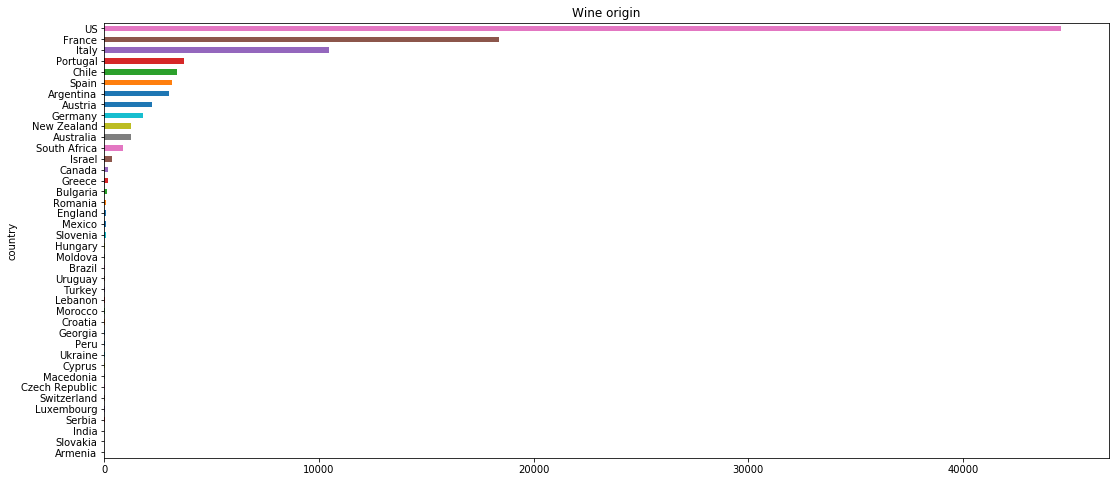

In [152]:
wine_origin.plot.barh(x='country', y='count',figsize=(18,8),title='Wine origin',legend=False);

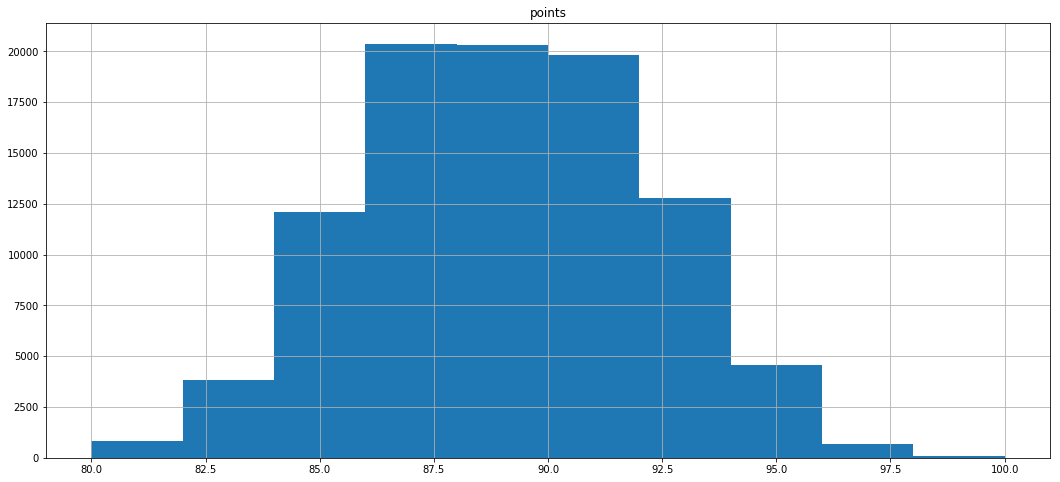

In [153]:
wine_data.hist(column='points',figsize=(18,8));

In [154]:
country_province=wine_data.groupby(['country', 'province']).size().sort_values(ascending=True) .reset_index(name='count').drop_duplicates(subset='province')

In [155]:
country_province['country_province']=country_province['country']+'-'+country_province['province']
country_province=country_province.tail(20)

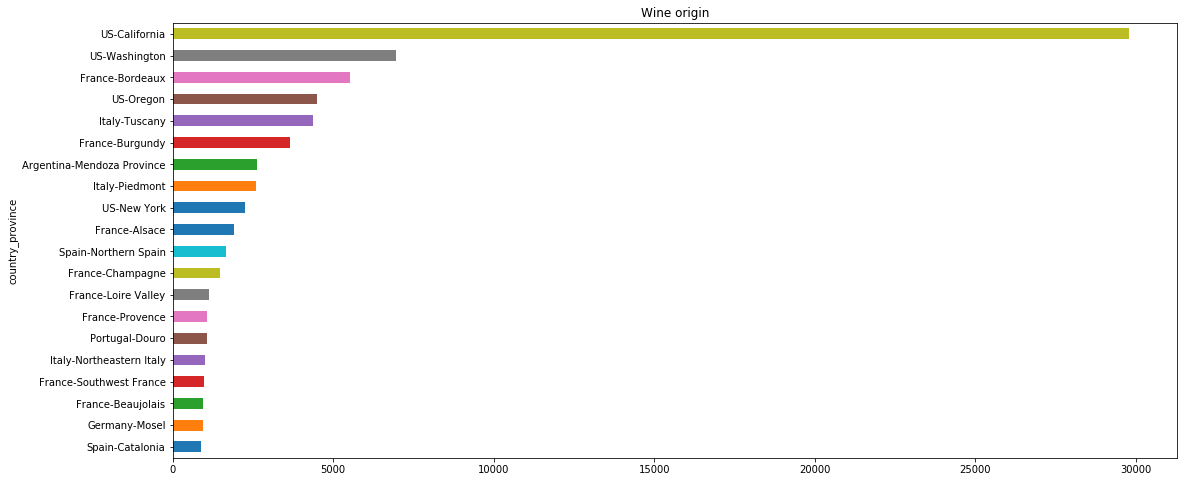

In [156]:
country_province.plot.barh(x='country_province', y='count',figsize=(18,8),title='Wine origin',legend=False);

In [173]:
country_variety=wine_data.groupby(['country', 'variety']).size().sort_values(ascending=True) .reset_index(name='count')

In [174]:
country_variety['country_variety']=country_variety['country']+'-'+country_variety['variety']
country_variety=country_variety.tail(20)

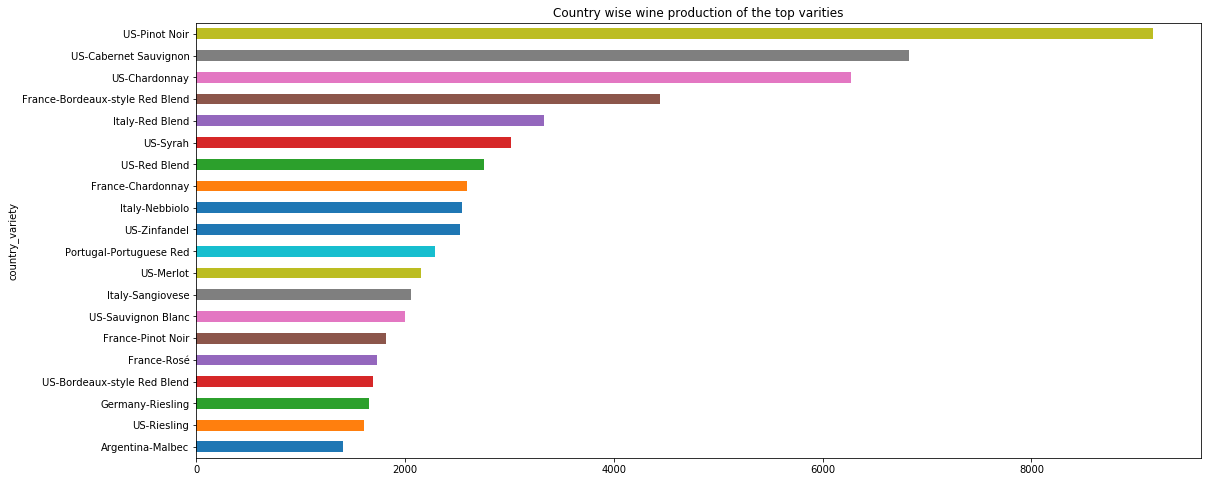

In [176]:
country_variety.plot.barh(x='country_variety', y='count',figsize=(18,8),title='Country wise wine production of the top varities',legend=False);

In [157]:
import warnings
warnings.simplefilter('ignore')

**Building predictive model**

Idea is to take user review as input and then predict the wine variety.

Checking class distribution.

In [158]:
class_distribution = (round(wine_data.variety.value_counts()/wine_data.shape[0]*100,2)).to_frame()
class_distribution.reset_index(inplace=True)

In [159]:
cols = ['variety','frequency']
class_distribution.columns = cols

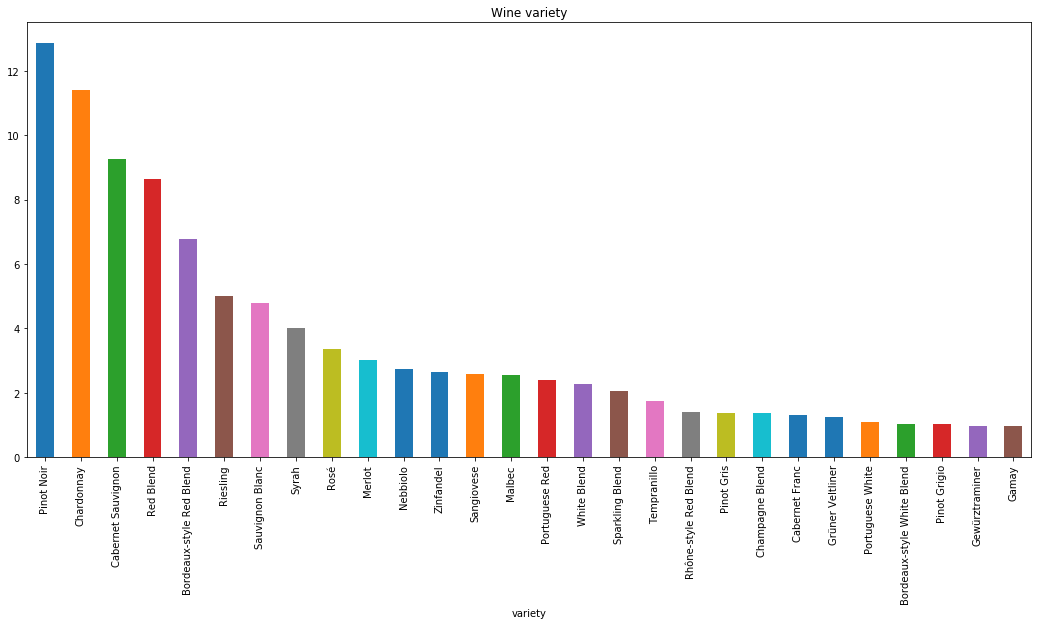

In [160]:
class_distribution.plot.bar(x='variety', y='frequency',figsize=(18,8),title='Wine variety',legend=False);

Splitting dataset into train and test

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X = wine_data[['review_description']]
y = wine_data['variety']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.20)

In [28]:
import re
from string import punctuation
import nltk
nltk.download('punkt')
#nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\biswa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [29]:
p = re.compile(r'[\s{}0-9]+'.format(re.escape(punctuation)))

In [30]:
from nltk.corpus import stopwords
stop_words = list(stopwords.words('english'))

In [31]:
def cleantexts(df,punctuation_patterns,col):
    df[col] = df[col].apply(lambda x: ' '.join([word.lower() for word in nltk.word_tokenize(x)]))
    df[col] = df[col].apply(lambda x:' '.join([ i for i in nltk.word_tokenize(x) if i not in stop_words and len(i)>1])) #and not i.isnumeric() and not i.isalpha()
    df[col] = df[col].apply(lambda x: re.sub(punctuation_patterns,' ',x))
    return df 

In [32]:
X_train = cleantexts(df=X_train,punctuation_patterns=p,col='review_description')

In [33]:
X_train.sample(3)

,review_description
49393,spicy rubbery subtle berry aromas come hard sm...
2497,planted laguna de santa rosa near sebastopol b...
9367,light color considerable acidity wine boasts c...


Creating tf-idf features

In [34]:
vectorizer_rvdesc = TfidfVectorizer(sublinear_tf =True,min_df=2,max_df=0.9,max_features = 2000)
x = vectorizer_rvdesc.fit_transform(X_train['review_description'])
feature_desc = pd.DataFrame(x.toarray())
columns = [vectorizer_rvdesc.get_feature_names()]
feature_desc.columns = columns
feature_desc.sample(3)

,abound,absolutely,abundance,abundant,acacia,accent,accented,accents,accessible,accompanied,...,youth,youthful,youthfully,zest,zestiness,zesty,zin,zinfandel,zingy,zippy
21654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
7155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.295686
13263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


Saving tf-idf vectorizer

In [69]:
pickle.dump(vectorizer_rvdesc, open('vectorizer_rvdesc.pkl', 'wb'))

Combining tf-idf features to create final featuremap

Fitting model

In [35]:
from sklearn.preprocessing import LabelEncoder

In [36]:
label_encoder = LabelEncoder()

In [37]:
y_label_train = label_encoder.fit_transform(y_train)

In [38]:
y_label_train

array([11, 17,  4, ...,  3, 20,  5])

Saving the label encoder

In [68]:
pickle.dump(label_encoder, open('label_encoder.pkl', 'wb'))

In [39]:
import xgboost as xgb
dtrain = xgb.DMatrix(data=feature_desc, label=y_label_train)

In [40]:
params = {
    'max_depth': 6,
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': 28,
    'n_gpus': 0
}

In [41]:
bst = xgb.train(params, dtrain)

Saving the trained model

In [66]:
import pickle

In [67]:
pickle.dump(bst, open('bst.sav', 'wb'))

Prediction on test data

In [70]:
X_test = cleantexts(df=X_test,punctuation_patterns=p,col='review_description')

In [71]:
x_test = vectorizer_rvdesc.transform(X_test['review_description'])
feature_desc_test = pd.DataFrame(x_test.toarray())
columns_test = [vectorizer_rvdesc.get_feature_names()]
feature_desc_test.columns = columns_test
feature_desc_test.sample(3)

,abound,absolutely,abundance,abundant,acacia,accent,accented,accents,accessible,accompanied,...,youth,youthful,youthfully,zest,zestiness,zesty,zin,zinfandel,zingy,zippy
14767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
y_label_test = label_encoder.transform(y_test)

In [73]:
y_label_test

array([24, 17, 14, ..., 15, 15,  2])

In [74]:
dtest = xgb.DMatrix(data=feature_desc_test)

In [75]:
pred = bst.predict(dtest)

In [76]:
pred

array([24.,  3., 14., ..., 15.,  0.,  2.], dtype=float32)

In [77]:
from sklearn.metrics import classification_report

print(classification_report(y_label_test, pred))

              precision    recall  f1-score   support

           0       0.57      0.70      0.63      1294
           1       0.58      0.31      0.41       199
           2       0.67      0.28      0.40       248
           3       0.57      0.67      0.61      1768
           4       0.76      0.41      0.53       262
           5       0.53      0.90      0.67      2173
           6       0.62      0.42      0.50       185
           7       0.73      0.45      0.55       188
           8       0.71      0.56      0.62       240
           9       0.59      0.42      0.49       489
          10       0.74      0.35      0.47       579
          11       0.69      0.70      0.70       522
          12       0.81      0.41      0.55       196
          13       0.73      0.42      0.54       264
          14       0.59      0.77      0.67      2455
          15       0.55      0.39      0.46       456
          16       0.54      0.32      0.40       211
          17       0.62    

Visualizing confusion matrix

In [78]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_label_test, pred)

In [79]:
pred = [int(i) for i in pred.tolist()]

In [84]:
label_encoder.inverse_transform(pred)

array(['Syrah', 'Cabernet Sauvignon', 'Pinot Noir', ..., 'Portuguese Red',
       'Bordeaux-style Red Blend', 'Cabernet Franc'], dtype=object)

In [81]:
orig_labels=label_encoder.classes_.tolist()

In [82]:
import seaborn as sns

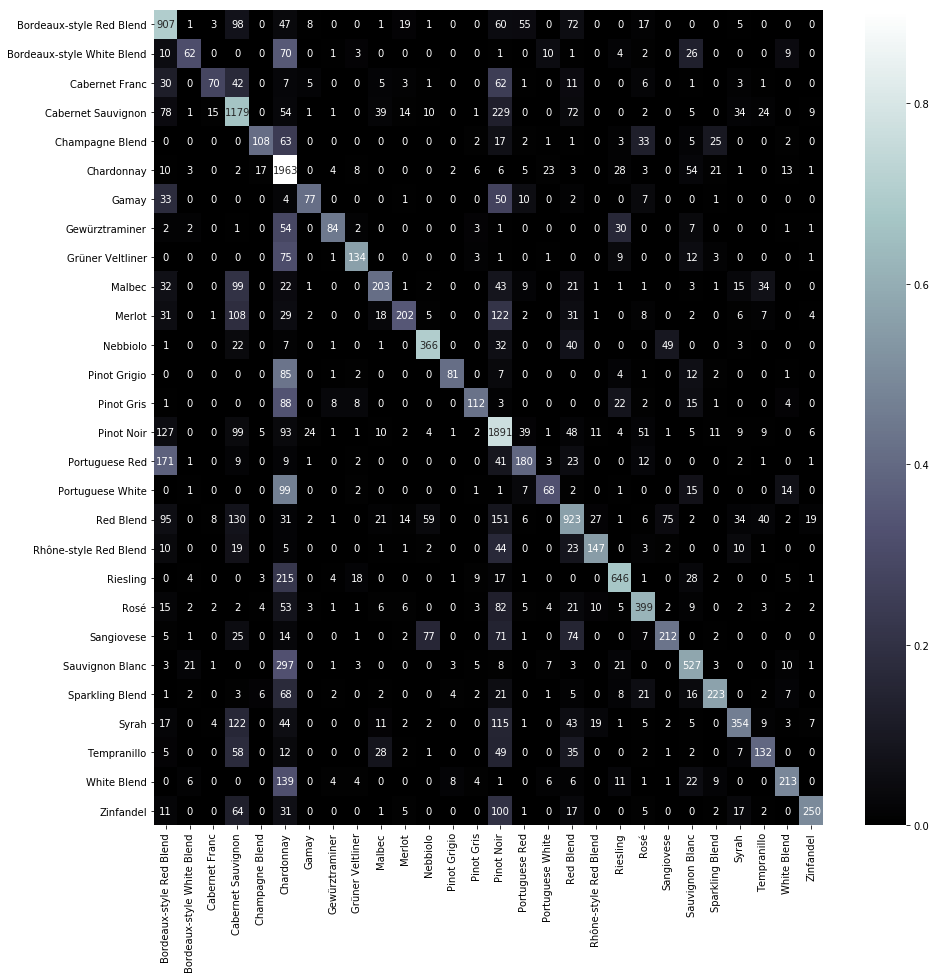

In [83]:
def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    plt.figure(figsize=[15, 15])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)
        plt.savefig('confusion-matrix.png')

plot_confusion_matrix(cm, orig_labels)